Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

In [0]:
# import os
# os.listdir('../input/')
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Parameter Settings
-------------------


In [0]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

FER2013 Data Loading
-------------------

We create both a training set and a test set.

In [0]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


import csv
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader

batch_size= 128

datas = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Project/fer2013/fer2013.csv")
datas
class DataLr:

    def __init__(self, data):

        data_train = data[data.Usage == 'Training']
        data_validation = data[data.Usage == 'PrivateTest']
        data_Test = data[data.Usage == 'PublicTest']

        self.Y_train = data_train['emotion']
        X_train = data_train['pixels']

        self.Y_test = data_Test['emotion']
        self.X_test = data_Test['pixels']
        X_train = X_train.str.split(" ", n=2304, expand=True)
        self.X_train = X_train.astype(np.int)

        self.train_samples = X_train.shape[0]


class DataSetFactory:

    def __init__(self):
        images = []
        emotions = []
        private_images = []
        private_emotions = []
        public_images = []
        public_emotions = []

        with open("/content/drive/My Drive/Colab Notebooks/Project/fer2013/fer2013.csv", 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                elif row[-1] == "PrivateTest":
                    private_emotions.append(int(row[0]))
                    private_images.append(Image.fromarray(face))
                elif row[-1] == "PublicTest":
                    public_emotions.append(int(row[0]))
                    public_images.append(Image.fromarray(face))

        print('training size %d : private val size %d : public val size %d' % (
            len(images), len(private_images), len(public_images)))
        train_transform = transforms.Compose([transforms.ToTensor()])
        
        val_transform = transforms.Compose([transforms.ToTensor()])
        
        test_transform = transforms.Compose([transforms.ToTensor()])
        
        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.private = DataSet(transform=val_transform, images=private_images, emotions=private_emotions)
        self.public = DataSet(transform=test_transform, images=public_images, emotions=public_emotions)

class DataSet(torch.utils.data.Dataset):

    def __init__(self, transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)


# DataLoaders provide various ways to get batches of examples.

def loaders(Data, batch_size):
    Data = DataSetFactory()
    train_loader = torch.utils.data.DataLoader(Data.training, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(Data.private, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(Data.public, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader, test_loader


Data = DataSetFactory()

train_loader, val_loader, test_loader = loaders(Data, batch_size)

training size 28709 : private val size 3589 : public val size 3589
training size 28709 : private val size 3589 : public val size 3589


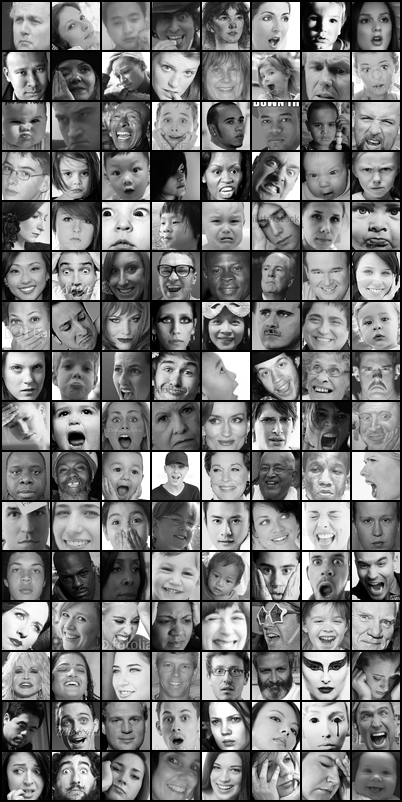

In [0]:
import torchvision
from torchvision.utils import save_image
from IPython.display import Image
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

fixed_x, _ = next(iter(train_loader))
save_image(fixed_x)
fixed_x = fixed_x.view(fixed_x.size(0), -1)

Image('real_image.png')

VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

class VariationalAutoencoder(nn.Module):
    def __init__(self, image_size=48*48, h_dim=400, z_dim=10):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 48*48), x.view(-1, 48*48), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1858324


Train VAE
--------

In [0]:
vae

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2304, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=2304, bias=True)
    (3): Sigmoid()
  )
)

In [0]:
model = vae
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def flatten(x):
    return to_var(x.view(x.size(0), -1))
epochs = 2
for epoch in range(epochs):
    for idx, (images, _) in enumerate(train_loader):
        images = flatten(images)
        images = images.view(-1, 48 * 48)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data/128))
    
            

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/2] Loss: 1615.475
Epoch[1/2] Loss: 1468.817
Epoch[1/2] Loss: 1417.049
Epoch[2/2] Loss: 1427.895
Epoch[2/2] Loss: 1406.128
Epoch[2/2] Loss: 1388.374


In [0]:
sample = Variable(torch.randn(400, 10))
recon_x = vae.decoder(sample)
fixed_x = fixed_x.view(fixed_x.size(0), -1)
recon_x, _, _ = vae(fixed_x)

save_image(recon_x.view(recon_x.size(0), -1).data.cpu(), 'sample_image.png')

In [0]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(5):
    train_loss_avg.append(0)
    num_batches = 0
    #  for batch_idx, (val, _) in enumerate(train_loader):
    #     val = val.view(val.view(image_batch.shape[0], -1))
    #     val = val.to(device)
    for batch_idx, (image_batch, _) in enumerate(train_loader):
        image_batch = image_batch.view(-1, 48 * 48)
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(image_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(image_batch)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss_avg[-1] / len(train_loader.dataset)))
    
    # train_loss_avg[-1] /= num_batches
    # print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Train Epoch: 0 [0/28709 (0%)]	Loss: 1406.245850
Train Epoch: 0 [128/28709 (0%)]	Loss: 2118.623291
Train Epoch: 0 [256/28709 (1%)]	Loss: 1480.755615
Train Epoch: 0 [384/28709 (1%)]	Loss: 1579.218994
Train Epoch: 0 [512/28709 (2%)]	Loss: 1598.567139
Train Epoch: 0 [640/28709 (2%)]	Loss: 1614.132202
Train Epoch: 0 [768/28709 (3%)]	Loss: 1543.779907
Train Epoch: 0 [896/28709 (3%)]	Loss: 1486.607178
Train Epoch: 0 [1024/28709 (4%)]	Loss: 1437.394653
Train Epoch: 0 [1152/28709 (4%)]	Loss: 1432.023926
Train Epoch: 0 [1280/28709 (4%)]	Loss: 1430.371582
Train Epoch: 0 [1408/28709 (5%)]	Loss: 1432.518188
Train Epoch: 0 [1536/28709 (5%)]	Loss: 1466.039673
Train Epoch: 0 [1664/28709 (6%)]	Loss: 1450.677979
Train Epoch: 0 [1792/28709 (6%)]	Loss: 1440.847168
Train Epoch: 0 [1920/28709 (7%)]	Loss: 1412.028931
Train Epoch: 0 [2048/28709 (7%)]	Loss: 1425.194214
Train Epoch: 0 [2176/28709 (8%)]	Loss: 1403.546997
Train Epoch: 0 [2304/28709 (8%)]	Loss: 1417.333618
Train Epoch: 0 [2432/28709 (

Plot Training Curve
--------------------

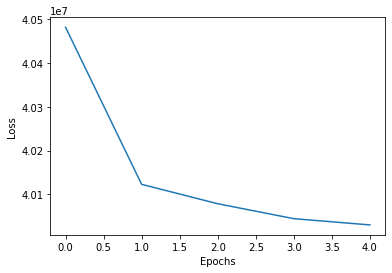

In [0]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()